## Imports and Installs

### Installs
No need to install OSMPythonTools as it is no longer used.

In [ ]:
!pip3 install OSMPythonTools

### Imports

In [ ]:
from OSMPythonTools.api import Api

In [ ]:
import geopandas as gpd

In [ ]:
import pandas as pd
import json
import csv
import os
import logging
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from shapely.geometry import Point, Polygon
import requests
import time
from google.colab import drive

## Connecting to Drive

We first mount the drive. This step requires permission to be given. Running the cell should open a permission page to allow colab access to google drive.

In [ ]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Setting the file directory to the data folder. All files will be referenced to this working directory.

In [ ]:
data_dir = "./gdrive/MyDrive/RL Delivery Data"

# See directory content
data = os.listdir(data_dir)
print("Files in directory : ", data)

Files in directory :  ['Hotspot Data', 'Original Location Data', 'Processed Location Data', 'Census Data', 'Results', 'distance_matrix.npy', 'time_matrix.npy', 'Q_boltzman.npy', 'Results Images', 'Q_epsilon.npy', 'Delivery Data', 'avg_hotspot_data.json', 'avg_intra_hotspot_location_data.json', 'avg_time_hotspot_location_data.npy', 'avg_distance_hotspot_location_data.npy', 'min_time_hotspot_location_data.npy', 'min_distance_hotspot_location_data.npy', 'max_time_hotspot_location_data.npy', 'max_distance_hotspot_location_data.npy']


# Pickup and Drop Locations
Using OSM, we can query locations that are suited for our study. We need those locations which can either provide food or act as a potential drop location for a customer. Thse locations can be queried using Overpass API that uses the OSM data. While it is possible to use the OSMPythonTools for queries the data uses python scripts, it is easier to query and visualise data from Overpass Turbo and directly download the data from the site in the `.geojson` format. The latter has been used for this notebook. These data files are stored in `Original Data` folder.

### Data Distribution
In OSM, these locations are rendered as `ammenities` and `building`. Detailed infomration can be found on the OSM wiki page - [Map Features](https://https://wiki.openstreetmap.org/wiki/Map_features)

<br>

The following `ammenties` / `buildings` are chosen as pickup locations:

| Type | Number of Locations |
| -------- | -------- |
| restaurant | 2189 |
| cafe | 741 |
| fast_food | 1243 |
| food_court | 15 |
| bakery | 364 |
| supermarket | 261 |
| **TOTAL** | **4813** |

<br>

The following `ammenties` / `buildings` are chosen as drop locations:

| Type | Number of Locations |
| -------- | -------- |
| residential | 5043 |
| apartments | 3302 |
| house | 1949 |
| detached | 750 |
| hotel | 131 |
| office | 590 |
| universty | 368 |
| college | 50 |
| dormitory | 64 |
| hospital | 105 |
| community_centre | 41 |
| **TOTAL** | **12393** |

### Approach 1: Using `.json` and OSM API
**[WARNING]** Depricated Approach, Do Not Run
<br>
Storing location coordinates of each pickup and drop point. The following implementation uses the OSM API to fetch the coordinates of the first `node` of the `way` as the approximate location of the `way`. However this is **NOT** an effecient way as the `node` information is akready stored within the file. But here for an example the pickup point data is fetched using API.

In [ ]:
# loading directotry of raw pickup locations
pick_data_dir = data_dir + "/Original Location Data/Pickup Point Data/"
pick_files = os.listdir(pick_data_dir)

# to ignore the "downloading data" warning given by OSM tools
logging.getLogger("OSMPythonTools").setLevel(logging.ERROR)

# initialising OSM API instance to search for lat and lon
api = Api()

for file_name in pick_files:
  file_dir = pick_data_dir + file_name

  with open(file_dir, "r") as file:
    data = json.load(file)
    print(file_dir)
    elements = data["elements"]

  loc_data = {}

  print("Starting ", file_name)
  count = 0;

  for element in elements:
    if (element["type"] != "way"):
        break

    result = api.query("way/" + str(element["id"]))
    lat = result.nodes()[0].lat()
    lon = result.nodes()[0].lon()
    loc_data[element["id"]] = {
        "apx:lat": lat,
        "apx:lon": lon
    }

    count +=1
    print(f"\r{count} locations completed", end="")

  # Serializing json
  json_object = json.dumps(loc_data, indent=4)

  # making file name for storing lat long of all `ways`.
  new_file_dir = file_dir[:-13]
  new_file_dir += "location_data.json"

  print("\nWriting into file")
  # writing into new file
  with open(new_file_dir, "w") as file:
      file.write(json_object)

  print("Completed ", file_name)


**[WARNING]** Do not run this cell. This is a depriocated approach.
Running this can cause deletion of files or unwanted alters to files. <br>
The larger drop points data can be populated using the node data within the downloaded file only. This is much faster (takes only a couple of seconds). The following code can be modified for pickup points also for fast processing.
<br>
However this is **still ineffecient**. Storing the data in `.geojson` allows to use the data as data frames in Geo Pandas library where we can use their in-built methods.

In [ ]:
# loading directotry of raw drop locations
drop_data_dir = data_dir + "/Original Location Data/Drop Point Data/"
drop_files = os.listdir(drop_data_dir)

for file_name in drop_files:
  file_dir = drop_data_dir + file_name

  with open(file_dir, "r") as file:
    data = json.load(file)
    print(file_dir)
    elements = data["elements"]

  loc_data = dict()
  node_loc = dict()

  print("Starting ", file_name)
  count = 0;

  for element in elements:
    if (element["type"] == "node"):
      node_loc[element["id"]] = {
          "lat" : element["lat"],
          "lon" : element["lon"]
      }

  for element in elements:
    if (element["type"] == "way"):

      loc_data[element["id"]] = {
            "apx:lat": node_loc[element["nodes"][0]]["lat"],
            "apx:lon": node_loc[element["nodes"][0]]["lon"]
        }


  # Serializing json
  json_object = json.dumps(loc_data, indent=4)

  # making file name for storing lat long of all `ways`.
  new_file_dir = file_dir[:-13]
  new_file_dir += "location_data.json"

  print("\nWriting into file")
  # writing into new file
  with open(new_file_dir, "w") as file:
      file.write(json_object)

  print("Completed ", file_name)

### Approach 2: Using `.geojson` and GeoPandas

Geojson provides easy and effecient to handle geo data. It has only one main requirement - every data frame element needs to have an attribute that contains geometry objects. Usually it is named as `geometry` or needs to be specified seperately if the name is different.

First drop unnecessary attributes. The Census Tract data contains many attributes that are not necessary for our analysis. We drop these columns to avoid storing excess data and taking extra time for computing queries. This becomes specially important when we have to perform joins among data frames.

In [ ]:
census_dir = data_dir + "/Census Data/Census Tracts 2010.geojson"
census_df = gpd.read_file(census_dir)

census_df = census_df.drop('statefp10', axis=1)
census_df = census_df.drop('name10', axis=1)
census_df = census_df.drop('commarea_n', axis=1)
census_df = census_df.drop('namelsad10', axis=1)
census_df = census_df.drop('commarea', axis=1)
census_df = census_df.drop('geoid10', axis=1)
census_df = census_df.drop('notes', axis=1)
census_df = census_df.drop('countyfp10', axis=1)

census_df.to_file(data_dir + "/Census Data/census_tract_data.geojson", driver="GeoJSON")

Like MySQL, GeoPandas also provides join operations on data frames using the geometry attribute. Doing a left-join on the locations and census tracts assigns every selected location to a census tract.
Also after joining the 2 data frames, uneccessary attributes from the OSM data are dropped. This significantly reduced file size (by almost 10 times in most cases!)
<br>
<br>
_Note: Throughout this notebook, the census tract ID is named as `tractce10` following the convension of the 2010 Census Tract Data taken from [Chicago Data Portal](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik)_

In [ ]:
census_dir = data_dir + "/Census Data/census_tract_data.geojson"
census_df = gpd.read_file(census_dir)

# loading directotry of raw pickup locations
pick_data_dir = data_dir + "/Original Location Data/Pickup Point Data/"
pick_files = os.listdir(pick_data_dir)

for file_name in pick_files:
  file_dir = pick_data_dir + file_name
  file_df = gpd.read_file(file_dir)

  join_left_df = file_df.sjoin(census_df, how="left")

  for column in join_left_df.columns.tolist():
    if (column not in ["@id", "name", "geometry", "amenity", "building", "shop", "tractce10"]):
      join_left_df = join_left_df.drop(column, axis=1)

  # making file name for storing lat long of all locations
  new_file_dir = data_dir + "/Processed Location Data/Pickup Point Data/" + file_name
  new_file_dir = new_file_dir[:-16]
  new_file_dir += "location_data.geojson"

  join_left_df.to_file(new_file_dir, driver="GeoJSON")

In [ ]:
census_dir = data_dir + "/Census Data/census_tract_data.geojson"
census_df = gpd.read_file(census_dir)

# loading directotry of raw drop locations
drop_data_dir = data_dir + "/Original Location Data/Drop Point Data/"
drop_files = os.listdir(drop_data_dir)

for file_name in drop_files:
  file_dir = drop_data_dir + file_name
  file_df = gpd.read_file(file_dir)

  join_left_df = file_df.sjoin(census_df, how="left")

  for column in join_left_df.columns.tolist():
    if (column not in ["@id", "name", "geometry", "amenity", "building", "shop", "tractce10"]):
      join_left_df = join_left_df.drop(column, axis=1)

  # making file name for storing lat long of all locations
  new_file_dir = data_dir + "/Processed Location Data/Drop Point Data/" + file_name
  new_file_dir = new_file_dir[:-16]
  new_file_dir += "location_data.geojson"

  join_left_df.to_file(new_file_dir, driver="GeoJSON")

# Sorting Data

Now that we have the cenus tract each loacation belongs to, it is advisable to store the locations of each census tract seperately. This will help in organising the data by census tract ID. The `amenity`, `building` and `shop` attributes will help in identifying the type of any location.

Locations in the Drop Points are all `ways`. However in the pickup points, they can be a `way` as well as a `node`. The geometry of a `way` is a `Polygon` whereas for `node` it is `Point`. The following code handles both types together. For detailed info about `ways` and `nodes`, kindly read the official wiki docs on [Elements](https://wiki.openstreetmap.org/wiki/Elements).

In [ ]:
census_data = dict()

# loading directotry of sorted by type pickup locations
pick_data_dir = data_dir + "/Processed Location Data/Pickup Point Data/"
pick_files = os.listdir(pick_data_dir)
print("Files for Pickup Points Data: ",pick_files)

for file_name in pick_files:
  file_dir = pick_data_dir + file_name

  with open(file_dir, 'r') as f:
    data = json.load(f)["features"]

    for element in data:
      properties = element["properties"]
      tract = properties["tractce10"]
      amenity = None
      building = None
      shop = None

      if "amenity" in properties.keys():
        amenity = properties["amenity"]
      if "building" in properties.keys():
        building = properties["building"]
      if "shop" in properties.keys():
        shop = properties["shop"]

      if (element["geometry"]["type"] == "Polygon"):
        coordinates = element["geometry"]["coordinates"][0]
        latitude = np.mean([point[1] for point in coordinates])
        longitude = np.mean([point[0] for point in coordinates])

      elif (element["geometry"]["type"] == "Point"):
        latitude = element["geometry"]["coordinates"][1]
        longitude = element["geometry"]["coordinates"][0]

      if tract not in census_data.keys():
        census_data[tract] = []

      census_data[tract].append({
            "id" : properties["id"],
            "amenity" : amenity,
            "building" : building,
            "shop": shop,
            "lat" : latitude,
            "lon" : longitude
        })

Repeating the same for drop locations

In [ ]:
# loading directotry of sorted by type drop locations
drop_data_dir = data_dir + "/Processed Location Data/Drop Point data/"
drop_files = os.listdir(drop_data_dir)
print("Files for Drop Points Data: ",drop_files)

for file_name in drop_files:
  file_dir = drop_data_dir + file_name

  with open(file_dir, 'r') as f:
    data = json.load(f)["features"]

    for element in data:
      properties = element["properties"]
      tract = properties["tractce10"]
      amenity = None
      building = None
      shop = None

      if "amenity" in properties.keys():
        amenity = properties["amenity"]
      if "building" in properties.keys():
        building = properties["building"]
      if "shop" in properties.keys():
        shop = properties["shop"]

      coordinates = element["geometry"]["coordinates"][0]
      latitude = np.mean([point[1] for point in coordinates])
      longitude = np.mean([point[0] for point in coordinates])

      if tract not in census_data.keys():
        census_data[tract] = []

      census_data[tract].append({
            "id" : properties["id"],
            "amenity" : amenity,
            "building" : building,
            "shop": shop,
            "lat" : latitude,
            "lon" : longitude
        })

This final cell writes the data into a `.json`

In [ ]:
json_object = json.dumps(census_data, indent=4)

with open (data_dir + "/Census Data/census_tract_wise_locations.json", 'w') as f:
  f.write(json_object)

# Analysing Data
Here we plot and analyse the loacations and census tracts to get visuals on the distribution of out data.

Plotting all the location on the chicago city map.

In [ ]:
census_dir = data_dir + "/Census Data/census_tract_data.geojson"
census_df = gpd.read_file(census_dir)

with open(data_dir + "/Census Data/census_tract_wise_locations.json", 'r') as f:
  data = json.load(f)

pickup_points = []
drop_points = []

for census_tract in data:
  for location in data[census_tract]:
    if (location['shop'] in ["supermarket","bakery"] or location['amenity'] in ["restaurant","cafe","fast_food","food_court"]):
      pickup_points.append(Point(location["lon"],location["lat"]))
    else:
      drop_points.append(Point(location["lon"],location["lat"]))

pickup_df = gpd.GeoSeries(pickup_points, crs='EPSG:4326')
drop_df = gpd.GeoSeries(drop_points, crs='EPSG:4326')

tract = gpd.GeoSeries(census_df.loc[:].geometry)

In [ ]:
size = (20,20)
base = tract.plot(color="white", edgecolor="gray", figsize = size)
pickup_layer = pickup_df.plot(ax=base, marker='o', color='green', markersize=2, figsize = size)
drop_layer = drop_df.plot(ax=pickup_layer, marker='o', color='blue', markersize=1, figsize = size)
drop_layer.plot()

In [ ]:
census_dir = data_dir + "/Census Data/census_tract_data.geojson"
census_df = gpd.read_file(census_dir)

tract_id = list()
tract_geometry = list()
count = 0

for i in range(len(census_df)):
  if (census_df.loc[i]['tractce10']) in selected_tracts:
    count+=1
    tract_id.append(census_df.loc[i]['tractce10'])
    tract_geometry.append(census_df.loc[i].geometry)

selected_df = gpd.GeoDataFrame({'tractce10':tract_id, 'geometry': tract_geometry}, crs='EPSG:4326')

hotspot_dir = data_dir + "/Hotspot Data/selected_hotspot_data.geojson"
hotspot_locations = gpd.read_file(hotspot_dir, crs='EPSG:4326')

size = (12,12)
tract = gpd.GeoSeries(selected_df.loc[:].geometry)
base = tract.plot(color="white", edgecolor="gray", figsize=size)
hotspot_locations.plot(ax = base, marker='o', color='red', markersize=5, figsize=size)

Plotting Census Tracts with labels.

In [ ]:
# Load census tract data
census_dir = data_dir + "/Census Data/census_tract_data.geojson"
census_df = gpd.read_file(census_dir)

# Set up the plot
fig, ax = plt.subplots(figsize=(50, 50))

# Plot the census tracts and add labels
base = census_df.plot(ax=ax, edgecolor='#DBC8C2', facecolor="#DBC8C2", linewidth=2, alpha=0.5)
# census_df.apply(lambda x: ax.text(x.geometry.centroid.x, x.geometry.centroid.y, x['tractce10'], fontsize=5, ha='center'), axis=1)

hotspot_dir = data_dir + "/Hotspot Data/hotspot_data.geojson"
hotspot_locations = gpd.read_file(hotspot_dir, crs='EPSG:4326')

hotspot_locations.plot(ax = base, marker='o', color='#c80000ff', markersize=60)

# Set the axis limits and title
ax.set_xlim([census_df.total_bounds[0], census_df.total_bounds[2]])
ax.set_ylim([census_df.total_bounds[1], census_df.total_bounds[3]])
ax.set_title('Census Tracts in Chicago with Hotspot Locations', fontsize = 45)
ax.set_xlabel('Latitude', fontsize = 40)
ax.set_ylabel('Longitude', fontsize = 40)

legend_lines = [Line2D([0], [0], marker='o', markersize=25, markeredgewidth=5, color='#c80000ff', linestyle='None')]
ax.legend(legend_lines, ['Hotpot Location'], loc=(0.8,0.95), fontsize=30)

# Show the plot
plt.show()

Plotting sample census tracts alomng with potential locations of the hotspots. The `blue` marker shows the center of the cernsus tract whereas the `purple` marker shows the center of the location in the census tract.
<br>
In most cases, the centyer of the tarct and the center of the locations are very close. But in many cases the center of locations within the census tract is better than the center of the census tract in the following ways:

1. Clearly the distribution within the census tract is not uniform. In most of the tracts, the locations are localised to a particular region. Because of this the center of the tract is quite far from most locations.

2. In irregulary shaped tracts, the center of the census tract can lie outside the tract which is not acceptable. The center of the locations, however, stays inside the tract.

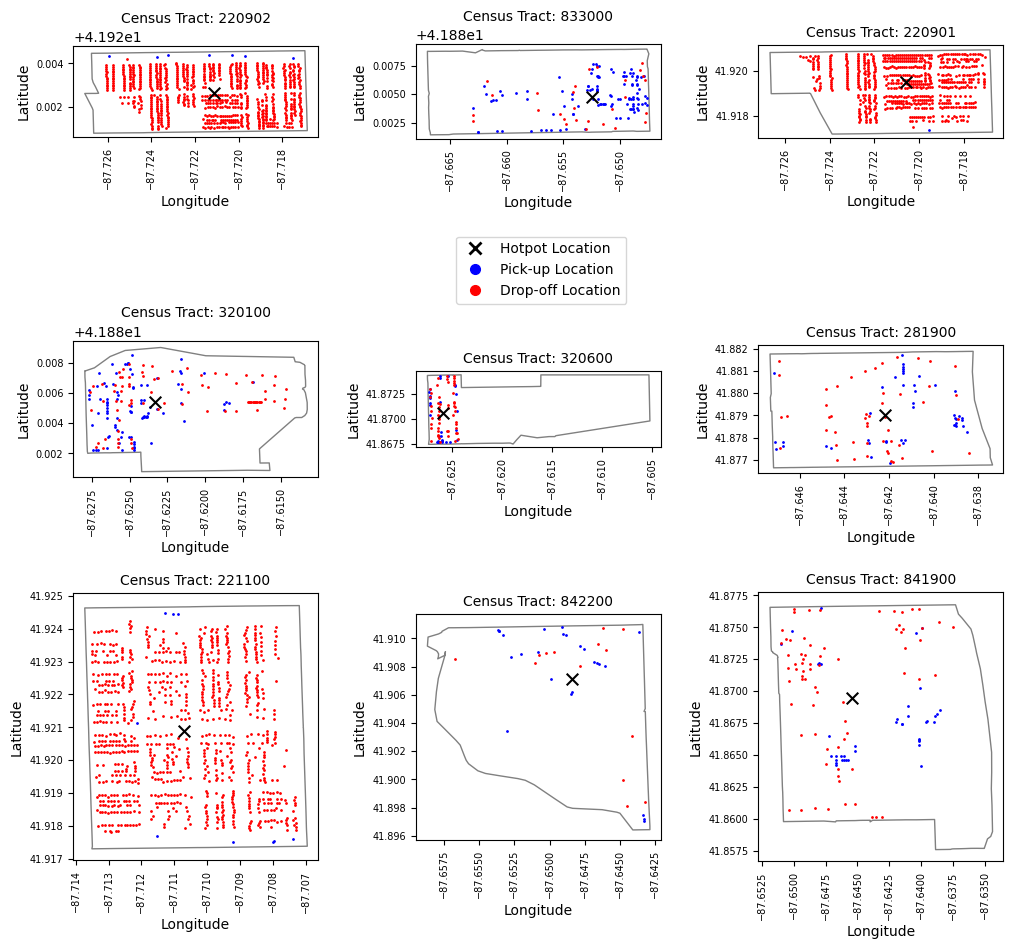

In [ ]:
census_dir = data_dir + "/Census Data/census_tract_data.geojson"
census_df = gpd.read_file(census_dir)

with open(data_dir + "/Census Data/census_tract_wise_locations.json", 'r') as f:
  data = json.load(f)

sample = ["220902","833000","220901","320100","320600","281900","221100","842200","841900"]

cols = 3
rows = 3
fig, axs = plt.subplots(nrows = rows, ncols=cols, figsize=(12, 12))

for index in range(len(sample)):
  census_tract = sample[index]
  pickup_points = []
  drop_points = []
  lat = []
  lon = []
  for location in data[census_tract]:
    if (location['shop'] in ["supermarket","bakery"] or location['amenity'] in ["restaurant","cafe","fast_food","food_court"]):
      pickup_points.append(Point(location["lon"],location["lat"]))
    else:
      drop_points.append(Point(location["lon"],location["lat"]))
    lat.append(location["lat"])
    lon.append(location["lon"])

  lat = pd.Series(lat)
  lon = pd.Series(lon)
  hotspot_lat = lat.mean()
  hotspot_lon = lon.mean()
  locations_mean = gpd.GeoSeries(Point(hotspot_lon,hotspot_lat))

  for i in range(801):
    if int((census_df.loc[i])["tractce10"]) == int(census_tract):
      tract = gpd.GeoSeries(census_df.loc[i].geometry)
      break

  pickup_locations = gpd.GeoSeries(pickup_points, crs='EPSG:4326')
  drop_locations = gpd.GeoSeries(drop_points, crs='EPSG:4326')
  tract = gpd.GeoSeries(tract.geometry)

  base = tract.plot(ax = axs[int((index)/cols)][index%cols], color="white", edgecolor="gray")
  layer1 = pickup_locations.plot(ax=base, marker='o', color='blue', markersize=1)
  layer2 = drop_locations.plot(ax=layer1, marker='o', color='red', markersize=1)
  # layer3 = tract.centroid.plot(ax=layer2, marker='x', color='orange', markersize=100)
  locations_mean.plot(ax=layer2, marker='x', color='black', markersize=70)


  axs[int((index)/cols)][index%cols].tick_params(axis='x', which='both', labelsize=7, rotation=90)
  axs[int((index)/cols)][index%cols].tick_params(axis='y', which='both', labelsize=7)
  axs[int((index)/cols)][index%cols].set_xlabel('Longitude')
  axs[int((index)/cols)][index%cols].set_ylabel('Latitude')
  axs[int((index)/cols)][index%cols].set_title('Census Tract: ' + str(sample[index]), fontsize = 10)

legend_lines = [Line2D([0], [0], marker='x', markersize=9, markeredgewidth=2, color='black', linestyle='None'),
                Line2D([0], [0], marker='o', markersize=7, markeredgewidth=1, color='blue', linestyle='None'),
                Line2D([0], [0], marker='o', markersize=7, markeredgewidth=1, color='red', linestyle='None')]
fig.legend(legend_lines, ['Hotpot Location', 'Pick-up Location', 'Drop-off Location'], loc=(0.45,0.68), fontsize=10)

plt.subplots_adjust(wspace=0.4, hspace=0.1)
plt.savefig(data_dir + "/Results Images/census_tract_data_point_distribution.png", dpi=300)

# Finding Hotspot Locations
Based on the analysis, the hotspot location is chosen as center (mean) of the location within the tract. We first store these locations in a seperate `.geojson` file

In [ ]:
with open(data_dir + "/Census Data/census_tract_wise_locations.json", 'r') as f:
  data = json.load(f)

tract_id = list()
hotspot_geometry = list()
num_locations = list()

for census_tract in data:
  lat = []
  lon = []
  for point in data[census_tract]:
    lat.append(point["lat"])
    lon.append(point["lon"])

  lat = pd.Series(lat)
  lon = pd.Series(lon)
  hotspot_lat = lat.mean()
  hotspot_lon = lon.mean()

  tract_id.append(census_tract)
  hotspot_geometry.append(Point(hotspot_lon,hotspot_lat))
  num_locations.append(len(data[census_tract]))


tract_gdf = gpd.GeoDataFrame({'tractce10': tract_id, 'geometry': hotspot_geometry, 'locations': num_locations}, crs='EPSG:4326')
tract_gdf.to_file(data_dir + '/Hotspot Data/hotspot_data.geojson', driver='GeoJSON')

Plotting the hotspot locations on Chicago Map.

In [ ]:
census_dir = data_dir + "/Census Data/census_tract_data.geojson"
census_df = gpd.read_file(census_dir, crs='EPSG:4326')

hotspot_dir = data_dir + "/Hotspot Data/hotspot_data.geojson"
hotspot_locations = gpd.read_file(hotspot_dir, crs='EPSG:4326')

size = (15,15)
tract = gpd.GeoSeries(census_df.loc[:].geometry)
base = tract.plot(color="white", edgecolor="gray", figsize=size)
hotspot_locations.plot(ax = base, marker='x', color='black', markersize=5, figsize=size)

We then make `csv` file to store the frequency of locations within each hotspot.

In [ ]:
with open (data_dir + "/Census Data/census_tract_wise_locations.json", 'r') as f:
  data = json.load(f)

with open (data_dir + "/Census Data/census_frequency.csv", 'w') as f:
  writer = csv.writer(f)
  for census_tract in data:
    writer.writerow([census_tract,len(data[census_tract])])

## Finding Neighbouring Hotspots

In [ ]:
hotspot_dir = data_dir + "/Hotspot Data/hotspot_data.geojson"
hotspot_locations = gpd.read_file(hotspot_dir, crs='EPSG:4326')

projected_hotspots = hotspot_locations.to_crs('EPSG:4326')
distances = projected_hotspots.distance(projected_hotspots.shift())
print(distances[4])

0.020314700967126727


<ipython-input-6-9912c0144e2c>:5: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = projected_hotspots.distance(projected_hotspots.shift())


# Selecting Hotspots
There are a total of `801` Census Tracts in the 2010 census data. Out of these `727` do not have any locations relevant to our research. Out of these too, `416` tracts have 10 or less locations. This makes these unvaviable to be chosen as hotspot locations.

## Approach 1: Using density/frequncy to select Hotspots

Using a density or frequency based method to select hotspots fails as it selects hotspots that are spread over a large area with empty patches in between. This will pose a problem for full coverage as well as make the working area for the model too large to be computationally feasible.

In [ ]:
census_dir = data_dir + "/Census Data/census_tract_data.geojson"
census_df = gpd.read_file(census_dir)

hotspot_dir = data_dir + "/Hotspot Data/hotspot_data.geojson"
hotspot_df = gpd.read_file(hotspot_dir)

census_df['tractce10'] = census_df['tractce10'].astype('string')
hotspot_df['tractce10'] = hotspot_df['tractce10'].astype('string')

merged_df = census_df.merge(hotspot_df, on='tractce10')
merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry_x')

tracts_geometry = []
selected_tracts = []
count = 0

avg_density = 0
for i in range(len(merged_df)):
  avg_density += float(merged_df.loc[i, "locations"]) / float(merged_df.loc[i, "geometry_x"].area)

avg_density = avg_density/len(merged_df)

for i in range(len(merged_df)):
  density = float(merged_df.loc[i, "locations"]) / float(merged_df.loc[i, "geometry_x"].area)
  if  density > 200000 :
    count += 1
    selected_tracts.append(hotspot_df.loc[i, "tractce10"])
    tracts_geometry.append(census_df.loc[i].geometry)

print(count)

selected_df = gpd.GeoDataFrame({'tractce10': selected_tracts, 'geometry': tracts_geometry}, crs='EPSG:4326')

size = (15,15)
selected_df.plot(color="white", edgecolor="black", figsize=size)

In [ ]:
with open (data_dir + "/Census Data/census_frequency.csv", 'r') as f:
  reader = csv.reader(f)
  for line in reader:
    if line[0] != "null" and int(line[0]) in selected_tracts:
      print(line)

## Approach 2: Selecting only a part of the city
Cherry picking the census tracts to be used for training works better.

### SET 1

In [ ]:
# SET
selected_tracts = [
    '030101', '030102', '030103', '030104', '030601', '030603', '030604', '030701', '030703', '030706', '030800', '030900', '031000', '031100', '031200', '031300', '031400', '031501', '031502', '031700', '031800', '031900', '032100', '040100', '040201', '040202', '040401', '040402', '040600', '040700', '040800', '040900', '050100', '050200', '050300', '050500', '050600', '050700', '050800', '050900', '051000', '051100', '051200', '051300', '051400', '060100', '060200', '060300', '060400', '060500', '060800', '060900', '061000', '061100', '061200', '061500', '061800', '061901', '061902', '062000', '062100', '062200', '062300', '062400', '062500', '062600', '062700', '062800', '062900', '063000', '063100', '063200', '063301', '063302', '063303', '063400', '070101', '070102', '070103', '070200', '070300', '070400', '070500', '070600', '070700', '071000', '071100', '071200', '071300', '071400', '071500', '071600', '071700', '071800', '080100', '080201', '080202', '080300', '080400', '081000', '081100', '081201', '081202', '081300', '081401', '081402', '081403', '081500', '081600', '081700', '081800', '081900', '140100', '140200', '140301', '140302', '140601', '140602', '140701', '140702', '140800', '160400', '160501', '160502', '160601', '160602', '160700', '160800', '160900', '210100', '210501', '210502', '210601', '210602', '210700', '210800', '210900', '220300', '220400', '220500', '220601', '220602', '220701', '220702', '220901', '220902', '221000', '221100', '221200', '221300', '221400', '221500', '221600', '222200', '222500', '222600', '222700', '222800', '222900', '230100', '230200', '230300', '230400', '240200', '240300', '240500', '240600', '240700', '240800', '241000', '241100', '241200', '241300', '241400', '241500', '241600', '242000', '242100', '242200', '242300', '242400', '242500', '242600', '242800', '242900', '243000', '243100', '243200', '243300', '243400', '243500', '280100', '280400', '280800', '280900', '281900', '282700', '282800', '283100', '283200', '283800', '310200', '310300', '310400', '310500', '310600', '310700', '310800', '310900', '320100', '320400', '320600', '330100', '330200', '340300', '340400', '340500', '350100', '350400', '351000', '351100', '351400', '351500', '360200', '380100', '380200', '380700', '381200', '381400', '381500', '390100', '390200', '390300', '390400', '390500', '390600', '390700', '410100', '410200', '410500', '410600', '410700', '410800', '410900', '411000', '411100', '411200', '420100', '420200', '420300', '420400', '600400', '600600', '600700', '600900', '830700', '830800', '830900', '831000', '831100', '831800', '831900', '832000', '832100', '832200', '832300', '832400', '832500', '832600', '832900', '833000', '833100', '833300', '835800', '835900', '836000', '836200', '836300', '836400', '836500', '837800', '838000', '838100', '838200', '838300', '839000', '839100', '839200', '839500', '839600', '839700', '839800', '839900', '840000', '840100', '840200', '841000', '841100', '841200', '841300', '841900', '842000', '842200', '842300', '842900', '843200', '843600', '843700'
]

print(len(selected_tracts))
print(len(set(selected_tracts)))


308
308


### SET 2

The following `ammenties` / `buildings` are chosen as pickup locations for running the model:

| Type | Number of Locations |
| -------- | -------- |
| restaurant | 1578 |
| cafe | 507 |
| fast_food | 518 |
| food_court | 7 |
| bakery | 145 |
| supermarket | 87 |
| **TOTAL** | **2842** |

<br>

The following `ammenties` / `buildings` are chosen as drop locations for running the model:

| Type | Number of Locations |
| -------- | -------- |
| residential | 4185 |
| apartments | 2364 |
| house | 449 |
| detached | 280 |
| hotel | 105 |
| office | 435 |
| university | 141 |
| college | 30 |
| dormitory | 20 |
| hospital | 59 |
| community_center | 9 |
| **TOTAL** | **8077** |

In [ ]:
# SET 2
selected_tracts = [
    '030101', '030102', '030601', '030603', '030604', '030701', '030702', '030703', '030706', '030800', '030900', '031000', '031100', '031200', '031300', '031400', '031501', '031502', '031700', '031800', '031900', '032100', '040201', '040202', '040401', '040402', '040600', '040700', '040800', '040900', '050100', '050200', '050300', '050500', '050600', '050700', '050800', '050900', '051000', '051100', '051200', '051300', '051400', '060100', '060200', '060300', '060400', '060500', '060800', '060900', '061000', '061100', '061200', '061500', '061800', '061901', '061902', '062000', '062100', '062200', '062300', '062400', '062500', '062600', '062700', '062800', '062900', '063000', '063100', '063200', '063301', '063302', '063303', '063400', '070101', '070102', '070103', '070200', '070300', '070400', '070500', '070600', '070700', '071000', '071100', '071200', '071300', '071400', '071500', '071600', '071700', '071800', '080100', '080201', '080202', '080300', '080400', '081000', '081100', '081201', '081202', '081300', '081401', '081402', '081403', '081500', '081600', '081700', '081800', '081900', '220300', '220400', '220500', '220601', '220602', '220701', '220901', '220902', '221000', '221100', '221200', '221300', '221400', '221500', '221600', '222200', '222500', '222600', '222700', '222800', '222900', '230100', '230200', '230300', '240200', '240300', '240500', '240600', '240700', '240800', '241000', '241100', '241200', '241300', '241400', '241500', '241600', '242000', '242100', '242200', '242300', '242400', '242500', '242600', '242800', '242900', '243000', '243100', '243200', '243300', '243400', '243500', '280100', '280400', '280800', '280900', '281900', '282700', '282800', '283100', '283200', '283800', '320100', '320400', '320600', '330100', '330200', '830700', '830800', '830900', '831000', '831900', '832000', '832100', '832200', '832300', '832400', '832500', '832600', '832900', '833000', '833100', '833300', '837800', '838000', '838100', '838200', '838300', '839000', '839100', '841900', '842200', '842300', '842900', '843700'
]

print(len(selected_tracts))
print(len(set(selected_tracts)))


205
205


### SET 3

In [ ]:
# SET 3
selected_tracts = [
    '842200', '080400', '080300', '080201', '080202', '080100', '081202', '838300', '081000', '081100', '081201', '081300', '081401', '081402', '081403', '081500', '081600', '081700', '081800', '081900'
]

print(len(selected_tracts))
print(len(set(selected_tracts)))

20
20


### Analysing Selection

In [ ]:
with open(data_dir + "/Census Data/census_tract_wise_locations.json",'r') as f:
  data = json.load(f)

frequency = dict()

for tract in selected_tracts:
  for location in data[tract]:

    if location['amenity'] in frequency.keys():
      frequency[location['amenity']] += 1
    else:
      frequency[location['amenity']] = 1

    if location['building'] in frequency.keys():
      frequency[location['building']] += 1
    else:
      frequency[location['building']] = 1

    if location['shop'] in frequency.keys():
      frequency[location['shop']] += 1
    else:
      frequency[location['shop']] = 1

for key in frequency.keys():
  print(key, frequency[key])

In [ ]:
with open(data_dir + "/Census Data/census_tract_wise_locations.json",'r') as f:
  data = json.load(f)

count = dict()

for tract in selected_tracts:
  if len(data[tract]) in count.keys():
    count[len(data[tract])] += 1
  else :
     count[len(data[tract])] = 1

for key in count.keys():
  print(key, count[key])

In [ ]:
hotspot_dir = data_dir + "/Hotspot Data/hotspot_data.geojson"
hotspot_df = gpd.read_file(hotspot_dir)

selected_hotspot_tractce10 = []
selected_hotspot_locations = []
selected_hotspot_geometry = []

for i in range(len(hotspot_df)):
  if hotspot_df.loc[i]["tractce10"] in selected_tracts:
    selected_hotspot_tractce10.append(hotspot_df.loc[i]["tractce10"])
    selected_hotspot_locations.append(hotspot_df.loc[i]["locations"])
    selected_hotspot_geometry.append(hotspot_df.loc[i]["geometry"])

index = [i for i in range(len(selected_hotspot_tractce10))]

selected_hotspot_df = gpd.GeoDataFrame({"index":index, "tractce10":selected_hotspot_tractce10, "locations":selected_hotspot_locations, "geometry":selected_hotspot_geometry}, crs='EPSG:4326')

selected_hotspot_df.sort_values(by="tractce10")

selected_hotspot_dir = data_dir + "/Hotspot Data/selected_hotspot_data.geojson"
selected_hotspot_df.to_file(selected_hotspot_dir, driver="GeoJSON")


In [ ]:
census_dir = data_dir + "/Census Data/census_tract_data.geojson"
census_df = gpd.read_file(census_dir)

tract_id = list()
tract_geometry = list()
count = 0

for i in range(len(census_df)):
  if (census_df.loc[i]['tractce10']) in selected_tracts:
    count+=1
    tract_id.append(census_df.loc[i]['tractce10'])
    tract_geometry.append(census_df.loc[i].geometry)

selected_df = gpd.GeoDataFrame({'tractce10':tract_id, 'geometry': tract_geometry}, crs='EPSG:4326')

hotspot_dir = data_dir + "/Hotspot Data/selected_hotspot_data.geojson"
hotspot_locations = gpd.read_file(hotspot_dir, crs='EPSG:4326')

size = (12,12)
tract = gpd.GeoSeries(selected_df.loc[:].geometry)
base = tract.plot(color="white", edgecolor="gray", figsize=size)
hotspot_locations.plot(ax = base, marker='o', color='red', markersize=5, figsize=size)


# Getting Adjacency Matrix

In [ ]:
points = []

selected_hotspot_dir = data_dir + "/Hotspot Data/selected_hotspot_data.geojson"
selected_hotspot_df = gpd.read_file(selected_hotspot_dir)
selected_hotspot_df = selected_hotspot_df.sort_values(by='index')

for i in range(len(selected_hotspot_df)):
  hotspot = selected_hotspot_df.loc[i]
  # print(hotspot['index'], hotspot['tractce10'])
  point = str(hotspot.geometry.y) + "," + str(hotspot.geometry.x)
  points.append(point)

print(points)

In [ ]:
url = "https://graphhopper.com/api/1/matrix"

max_limit = 80

x_start = 0
x_end = max_limit
y_start = 0
y_end = max_limit

while x_start < len(points):
  y_start = 0
  y_end = max_limit

  while y_start < len(points):

    query = {
      "profile": "scooter_delivery",
      "from_point": points[x_start:x_end],
      "to_point": points[y_start:y_end],
      "out_array": ["distances","times","weights"],
      "fail_fast": "true",
      "key": "81759ba7-6e63-4c3e-8692-bb40797bfab2"
    }

    response = requests.get(url, params=query)
    data = response.json()

    if y_start == 0:
      row_distances = np.array(data['distances'])
      row_times = np.array(data['times'])
      row_weights = np.array(data['weights'])
    else:
      row_distances = np.concatenate((row_distances,np.array(data['distances'])), axis=1)
      row_times = np.concatenate((row_times,np.array(data['times'])), axis=1)
      row_weights = np.concatenate((row_weights,np.array(data['weights'])), axis=1)

    y_start = y_end
    y_end += max_limit
    if y_end > len(points): y_end = len(points)

    print("Sleeping...")
    time.sleep(60)
    print("Done Sleeping!!!\n")

  if x_start == 0:
    distances = row_distances
    times = row_times
    weights = row_weights
  else:
    distances = np.concatenate((distances, row_distances), axis=0)
    times = np.concatenate((times, row_times), axis=0)
    weights = np.concatenate((weights, row_weights), axis=0)

  x_start = x_end
  x_end += max_limit
  if x_end > len(points): x_end = len(points)

In [ ]:
selected_tracts = ["070600", "081900", "070400", "071800", "070500", "071000", "081100", "838300", "832500", "071100", "842200", "832600", "070700", "081000", "080400", "081300", "081401", "081201", "081600", "080300", "081500", "081800", "081700", "320100"]
hotspot_location = dict()

selected_hotspot_dir = data_dir + "/Hotspot Data/selected_hotspot_data.geojson"
selected_hotspot_df = gpd.read_file(selected_hotspot_dir)

for i in range(len(selected_hotspot_df)):
  hotspot = selected_hotspot_df.loc[i]
  if (hotspot['tractce10'] in selected_tracts):
    hotspot_location[hotspot['tractce10']] = str(hotspot.geometry.y) + "," + str(hotspot.geometry.x)

print(len(hotspot_location))
print(hotspot_location)

24
{'842200': '41.90713568156853,-87.64842870043667', '080300': '41.908006897771145,-87.63564568940431', '320100': '41.88539433758617,-87.62330592653113', '081600': '41.89155180212583,-87.62883730798983', '081500': '41.892761665198236,-87.62626111746584', '832600': '41.91549444476824,-87.65225920135377', '838300': '41.90184648292641,-87.63870570473755', '070400': '41.92877467873304,-87.65646265727851', '832500': '41.92282026972684,-87.6629363037685', '071000': '41.92297727298006,-87.65554413988484', '071100': '41.92121299594485,-87.65083363019836', '081800': '41.892451515425996,-87.63665722669185', '081300': '41.89869663556963,-87.62133175487784', '081700': '41.89136879115512,-87.63178340069605', '070600': '41.927082572,-87.665160616', '071800': '41.9153651665873,-87.64724767535715', '081900': '41.89784405511628,-87.64231493472869', '080400': '41.90887687285336,-87.63985334238936', '081100': '41.90056518960464,-87.62897560123885', '081201': '41.898920801676056,-87.62650936444527', '081

In [ ]:
with open (data_dir + "/Census Data/census_tract_wise_locations.json", 'r') as f:
  data = json.load(f)

hotspot_points = dict()
for hotspot in selected_tracts:
  hotspot_points[hotspot] = list()

for hotspot in selected_tracts:
  for loc in data[hotspot]:
    hotspot_points[hotspot].append(str(loc['lat']) + "," + str(loc['lon']))

In [ ]:
url = "https://graphhopper.com/api/1/matrix"
count = 0

avg_hotspot_data = dict()

for hotspot in selected_tracts:
  if (len(hotspot_points[hotspot]) <= 128):
    continue

  query = {
        "profile": "scooter_delivery",
        "from_point": [hotspot_location[hotspot]],
        "to_point": hotspot_points[hotspot][0:160],
        "out_array": ["distances","times","weights"],
        "fail_fast": "true",
        "key": "212f91ea-5ad8-4c1b-937b-b10a5c5211fa"
  }
  response = requests.get(url, params=query)
  data = response.json()
  print(data)
  avg_hotspot_data[hotspot] = dict()
  avg_hotspot_data[hotspot]["distance"] = sum(data['distances'][0])/len(data['distances'][0])
  avg_hotspot_data[hotspot]["time"] = sum(data['times'][0])/len(data['times'][0])
  count += len(hotspot_points[hotspot])

  time.sleep(60)

In [ ]:
avg_hotspot_location_data = dict()

for hotspot in selected_tracts:
  avg_hotspot_location_data[hotspot] = dict()

In [ ]:
url = "https://graphhopper.com/api/1/matrix"
count = 0

for hotspot in selected_tracts[-2:]:
  max_limit = 80
  points = hotspot_points[hotspot]

  x_start = 0
  x_end = max_limit
  y_start = 0
  y_end = max_limit

  while x_start < len(points):
    y_start = 0
    y_end = max_limit

    while y_start < len(points):

      while (True):
        query = {
          "profile": "scooter_delivery",
          "from_point": points[x_start:x_end],
          "to_point": points[y_start:y_end],
          "out_array": ["distances","times","weights"],
          "fail_fast": "true",
          "key": "fc2f479f-5901-4152-9483-3f9fcb65c254"
        }

        response = requests.get(url, params=query)
        data = response.json()
        print(data)
        if 'message' in data.keys():
          time.sleep(60)
          continue
        break

      if y_start == 0:
        row_distances = np.array(data['distances'])
        row_times = np.array(data['times'])
        row_weights = np.array(data['weights'])
      else:
        row_distances = np.concatenate((row_distances,np.array(data['distances'])), axis=1)
        row_times = np.concatenate((row_times,np.array(data['times'])), axis=1)
        row_weights = np.concatenate((row_weights,np.array(data['weights'])), axis=1)

      y_start = y_end
      y_end += max_limit
      if y_end > len(points): y_end = len(points)

    if x_start == 0:
      distances = row_distances
      times = row_times
      weights = row_weights
    else:
      distances = np.concatenate((distances, row_distances), axis=0)
      times = np.concatenate((times, row_times), axis=0)
      weights = np.concatenate((weights, row_weights), axis=0)

    x_start = x_end
    x_end += max_limit
    if x_end > len(points): x_end = len(points)

  avg_hotspot_location_data[hotspot]['min_distance'] = int(np.min(distances[distances != 0]))
  avg_hotspot_location_data[hotspot]['max_distance'] = int(np.max(distances))
  avg_hotspot_location_data[hotspot]['mean_distance'] = float(np.sum(distances) / (len(points)*len(points) - len(points)))

  avg_hotspot_location_data[hotspot]['min_time'] = int(np.min(times[times != 0]))
  avg_hotspot_location_data[hotspot]['max_time'] = int(np.max(times))
  avg_hotspot_location_data[hotspot]['mean_time'] = float(np.sum(times) / (len(points)*len(points) - len(points)))

  print(hotspot)

In [ ]:
# keys = [
#     'fc2f479f-5901-4152-9483-3f9fcb65c254',
#     '6fd2d8f2-eefa-44a3-9fb7-4f0791ea27ba',
#     'ff9d785c-c5d7-4623-afb2-66f42639f1cd',
#     '4ff2a7e3-cc93-4084-ba93-d15f50207a3e',
#     'd791af75-c946-4799-b5f5-b907f1a3b521'
# ]

keys = [
    '8fb75536-2409-44ce-aa28-28a93f406dc8',
    'fffc6cfc-4271-4543-80c6-eb961c6f420c',
    '72afc622-533c-410b-8fe5-7bb20762035c',
    '7a9ce153-fb5f-4cc6-b315-ed9395cf6209',
    '11e7a49d-bf1c-4d4a-bd5e-c6754e7ef628',
    '96d20088-b7c2-4069-ba01-579c1e7d4b20'
]

tract_to_new_index = {'842200': 0, '080300': 1, '320100': 2, '081600': 3, '081500': 4, '832600': 5, '838300': 6, '070400': 7, '832500': 8, '071000': 9, '071100': 10, '081800': 11, '081300': 12, '081700': 13, '070600': 14, '071800': 15, '081900': 16, '080400': 17, '081100': 18, '081201': 19, '081401': 20, '081000': 21, '070700': 22, '070500': 23}

In [ ]:
max_distance = np.zeros((24, 24))
min_distance = np.zeros((24, 24))
avg_distance = np.zeros((24, 24))

max_time = np.zeros((24, 24))
min_time = np.zeros((24, 24))
avg_time = np.zeros((24, 24))

In [ ]:
for i in range(len(selected_tracts)-5):
  hotspot1 = selected_tracts[i]
  points1 = hotspot_points[hotspot1]
  index1 = tract_to_new_index[hotspot1]

  for j in range(i+1,len(selected_tracts)-5):
    hotspot2 = selected_tracts[j]
    points2 = hotspot_points[hotspot2]
    index2 = tract_to_new_index[hotspot2]

    if (avg_distance[index1][index2] == 0):
      continue
    print(hotspot1, hotspot2)

In [ ]:
url = "https://graphhopper.com/api/1/matrix"
count = 0
max_limit = 80
index = 0

for i in range(len(selected_tracts)-5):
  hotspot1 = selected_tracts[i]
  points1 = hotspot_points[hotspot1]
  index1 = tract_to_new_index[hotspot1]

  for j in range(i+1,len(selected_tracts)-5):
    hotspot2 = selected_tracts[j]
    points2 = hotspot_points[hotspot2]
    index2 = tract_to_new_index[hotspot2]

    if (avg_distance[index1][index2] == 0):
      continue

    x_start = 0
    x_end = max_limit
    y_start = 0
    y_end = max_limit

    while x_start < len(points1):
      y_start = 0
      y_end = max_limit

      while y_start < len(points2):

        while (True):
          query = {
            "profile": "scooter_delivery",
            "from_point": points1[x_start:x_end],
            "to_point": points2[y_start:y_end],
            "out_array": ["distances","times","weights"],
            "fail_fast": "true",
            "key": keys[index]
          }

          response = requests.get(url, params=query)
          data = response.json()
          print(data)

          if 'message' in data.keys():
            if (index==len(keys)-1):
              index = 0
              time.sleep(60)
              continue
            else:
              index += 1
          else:
            break

        if y_start == 0:
          row_distances = np.array(data['distances'])
          row_times = np.array(data['times'])
          row_weights = np.array(data['weights'])
        else:
          row_distances = np.concatenate((row_distances,np.array(data['distances'])), axis=1)
          row_times = np.concatenate((row_times,np.array(data['times'])), axis=1)
          row_weights = np.concatenate((row_weights,np.array(data['weights'])), axis=1)

        y_start = y_end
        y_end += max_limit
        if y_end > len(points2): y_end = len(points2)

      if x_start == 0:
        distances = row_distances
        times = row_times
        weights = row_weights
      else:
        distances = np.concatenate((distances, row_distances), axis=0)
        times = np.concatenate((times, row_times), axis=0)
        weights = np.concatenate((weights, row_weights), axis=0)

      x_start = x_end
      x_end += max_limit
      if x_end > len(points1): x_end = len(points1)

    min_distance[index1][index2] = int(np.min(distances[distances != 0]))
    max_distance[index1][index2] = int(np.max(distances))
    avg_distance[index1][index2] = float(np.sum(distances) / (len(points1)* len(points2)))

    min_time[index1][index2] = int(np.min(times[times != 0]))
    max_time[index1][index2] = int(np.max(times))
    avg_time[index1][index2] = float(np.sum(times) / (len(points1)* len(points2)))

    min_distance[index2][index1] = min_distance[index1][index2]
    max_distance[index2][index1] = max_distance[index1][index2]
    avg_distance[index2][index1] = avg_distance[index1][index2]

    min_time[index2][index1] = min_time[index1][index2]
    max_time[index2][index1] = max_time[index1][index2]
    avg_time[index2][index1] = avg_time[index1][index2]

    print(hotspot1, hotspot2)

In [ ]:
json_object = json.dumps(avg_hotspot_location_data, indent=4)

with open (data_dir + "/avg_hotspot_location_data.json", 'w') as f:
  f.write(json_object)

In [ ]:
np.save(data_dir + "/avg_distance_hotspot_location_data.npy", avg_distance)
np.save(data_dir + "/avg_time_hotspot_location_data.npy", avg_time)

In [ ]:
np.save(data_dir + "/min_distance_hotspot_location_data.npy", min_distance)
np.save(data_dir + "/min_time_hotspot_location_data.npy", min_time)

In [ ]:
np.save(data_dir + "/max_distance_hotspot_location_data.npy", max_distance)
np.save(data_dir + "/max_time_hotspot_location_data.npy", max_time)

In [ ]:
a = np.load(data_dir + "/avg_distance_hotspot_location_data.npy")

In [ ]:
np.save(data_dir + "/Hotspot Data/distance_adjacency_matrix.npy", distances)
np.save(data_dir + "/Hotspot Data/time_adjacency_matrix.npy", times)
np.save(data_dir + "/Hotspot Data/weight_adjacency_matrix.npy", weights)

In [ ]:
a = np.load(data_dir + "/Hotspot Data/distance_adjacency_matrix.npy")
max = 0
for i in range(len(a)):
  for j in range(len(a[0])):
    if a[i][j] > max:
      max = a[i][j]

print(max)

17523


# REFERENCES

API Wiki Docs:
1. [OSM Python Tools](https://github.com/mocnik-science/osm-python-tools) - Github Page for library documentation.
2. [Overpass API Wiki](https://https://wiki.openstreetmap.org/wiki/Overpass_API) - Overpass API Language documentation wiki page.
3. [Overpass Turbo](https://https://overpass-turbo.eu/) - Online editor to test queries.

Open Street Map Wiki Docs:
1. [Map Features](https://wiki.openstreetmap.org/wiki/Map_features)
2. [Elements](https://wiki.openstreetmap.org/wiki/Elements)